In [1]:
from gekko import GEKKO
import numpy as np
import pandas as pd


In [2]:
def solve_best_response(sum_other_actions, beta, gamma, e_max):
    model = GEKKO(remote=False, name='model')

    T = len(sum_other_actions)
    mat0 = model.Const(851, name='mat0')              # Initial Concentration in atmosphere 2015 (GtC)
    mu0 = model.Const(460, name='mu0')                # Initial Concentration in upper strata 2015 (GtC)
    ml0 = model.Const(1740, name='ml0')               # Initial Concentration in lower strata 2015 (GtC)

    z1ref = model.Const(588, name='z1ref')            # Equilibrium concentration atmosphere (GtC)
    mueq = model.Const(360, name='mu')                # Equilibrium concentration in upper ocean layer (GtC)
    mleq = model.Const(1720, name='ml')               # Equilibrium concentration in lower ocean layer (GtC)

    ### Climate model parameters

    t2xco2 = model.Const(3.1, name='tco2')            # Equilibrium temperature increase for CO2 doubling
    eta = model.Const(3.6813, name='eta')             # Forcings of equilibrium CO2 doubling (Wm-2)
    tatm0   = model.Const(0.85, name='t0')            # Initial atmospheric temp change (C from 1900)
    tocean0 = model.Const(.0068, name='to0')          # Initial lower stratum temp change (C from 1900) 


    b11 = model.Const(88/ 100, name = 'b11')                  # Carbon cycle transition matrix 
    b12 = model.Const(1 - b11, name = 'b12')                  # Carbon cycle transition matrix    
    b21 = model.Const(b12 * z1ref / mueq , name = 'b21')      # Carbon cycle transition matrix                
    b23 = model.Const(0.7/ 100, name = 'b23')                 # Carbon cycle transition matrix 
    b22 = model.Const(1 - b21 -b23, name = 'b22')             # Carbon cycle transition matrix            
    b32 = model.Const(b23 * mueq/mleq, name = 'b32')          # Carbon cycle transition matrix            
    b33 = model.Const(1 - b32, name = 'b33')                  # Carbon cycle transition matrix    

    Bz1 = model.Const(5/3.666, name='Bz1')                            # Coefficient for the emission C02 in the atmosphere 
    eland0 = 2.6                                                      # Carbon emissions from land 2015 (GtCO2 per year) 
    deland = .115                                                     # Decline rate of land emissions (per period)      

    etree = [model.Intermediate(eland0*(1-deland)**(t*5), name= 'etree_{}'.format(t)) for t in range(T)]

    fex0 = model.Const(0.5, name='fex0')                                                        # 2015 forcings of non-CO2 GHG (Wm-2)
    fex1 = model.Const(1  , name='fex1')                                                        # 2100 forcings of non-CO2 GHG (Wm-2)                           
    F_EX  = []                                                        # Exogeneous forcing for other greenhouse gases

    for t in range(T):
        if t <=17:                                #CHANGEMENT VIS DE DICE formule 
            F_EX.append(model.Intermediate(fex0 + (fex1 - fex0)/17 * t, name='F_EX_{}'.format(t)))
        else: 
            F_EX.append(model.Const(1, name='F_EX_{}'.format(t)))

    ### Matrix A_y

    c1 = model.Const(0.1005, name = 'c1')                         # Climate equation coeficient for upper level 
    c2 = model.Const(eta / t2xco2, name = 'c2')
    c3 = model.Const(0.088, name = 'c3')                          # Transfer coefficient upper to lower layer
    c4 = model.Const(0.025, name = 'c4')                          # Transfer coefficient for lower layer

    xi1 = model.Intermediate(1 - c1*c2 - c1*c3)
    xi2 = model.Intermediate(c1*c3)
    xi4 = model.Intermediate(1 - c4)
    #Variables
    action = [model.Var(value=0, lb=0, ub=e_max) for i in range(T)]


    beta = [model.Const(beta[i], name='b_{}'.format(i)) for i in range(len(beta))]
    gamma = [model.Const(gamma[i], name='g_{}'.format(i)) for i in range(len(gamma))]
    
    sum_other_actions = [ model.Param(sum_other_actions[t], name='S_{}'.format(t)) for t in range(T)]


    z_at = [mat0]
    z_oc = [mu0 ]
    z_do = [ml0 ]
    
    for t in range(T-1):
        z_at.append(model.Intermediate(z_at[t] * b11 + z_oc[t] * b21                 + Bz1 * (action[t] + sum_other_actions[t] + etree[t]), name= 'z_at_{}'.format(t))) 
        z_oc.append(model.Intermediate(z_at[t] * b12 + z_oc[t] * b22 + z_do[t] * b32 , name= 'z_oc_{}'.format(t)))
        z_do.append(model.Intermediate(                z_oc[t] * b23 + z_do[t] * b33 , name= 'z_do_{}'.format(t)))  

    F = [eta * model.log(z_at[t] / z1ref)/model.log(2) + F_EX[t] for t in range(T)]

    temp_at = [tatm0  ]
    temp_oc = [tocean0]

    for t in range(T-1) :
        temp_at.append(model.Intermediate(xi1 * temp_at[t] + xi2 * temp_oc[t] + c1 * F[t+1], name='temp_at_{}'.format(t)))
        temp_oc.append(model.Intermediate(c4 * temp_at[t] + xi4 * temp_oc[t], name='temp_oc_{}'.format(t)))
    
    model.Maximize(model.sum([beta[2] * action[t]**2  + beta[1]*(action[t]) + beta[0] for t in range(T-1)]))        # Benefit part from 0 to T-1
    model.Minimize(model.sum([gamma[1] * temp_at[t] +gamma[2] * temp_at[t]**2 for t in range(1,T)]))                # Damage part from 1 to T because the damage are only projected 

    model.options.IMODE = 3
    model.solve(disp=False)
    action = np.array([action[t][0] for t in range(T)])
    model.cleanup()
    return action


In [3]:
def best_response_dynamic(list_action, e_max, beta , gamma , step_criterion : int, utility_criterion : float, diplay_progress=True):

    N, T = np.shape(list_action)

    #Const

    loss = 1000
    k = 0
    inital_action = np.copy(list_action)
    list_of_all_action = [inital_action]

    while (loss > utility_criterion) and (k < step_criterion):
        list_action = np.copy(list_of_all_action[-1])
        if diplay_progress:
            print('k:', k)
            print('loss:', loss)
        for indice in range(N):
            list_action = list_of_all_action[-1]
            sum_other_actions = np.sum(list_action, axis = 0) - list_action[indice]

        
            list_action[indice] = solve_best_response(sum_other_actions,beta[:,indice], gamma[:,indice], e_max[indice])

        k +=1
        loss =  sum([sum( [(list_action[i][t] - list_of_all_action[-1][i][t])**2 for i in range(N)]) 
                                 for t in range(T)])
        
        list_of_all_action.append(list_action)
    if diplay_progress:
        if step_criterion <= k :
            print("Reach the step criterion.")
        if loss <= utility_criterion :
            print("Reach the utlity criterion in {} steps.".format(k))
    return list_of_all_action[-1]


In [4]:
data = pd.read_csv("data/data_of_interest.csv")
print(data)
e_max = data.loc[data['Entity']=='China','CO2 emission in Gt 2020']
print(e_max)

           Entity  Land area (sq. km)  Land ratio  Population 2020  \
0           China        9.424703e+06    0.222878     1.439324e+09   
1          Russia        1.637687e+07    0.387285     1.459345e+08   
2           India        2.973190e+06    0.070311     1.380004e+09   
3  European Union        3.999622e+06    0.094584     4.474795e+08   
4   United States        9.147420e+06    0.216321     3.310026e+08   
5           Japan        3.645000e+05    0.008620     1.264765e+08   

   Population 2020 ratio  CO2 emission in Gt 2020  
0               0.371897                10.667887  
1               0.037707                 1.577136  
2               0.356570                 2.441792  
3               0.115621                 2.598575  
4               0.085526                 4.712771  
5               0.032679                 1.030775  
0    10.667887
Name: CO2 emission in Gt 2020, dtype: float64


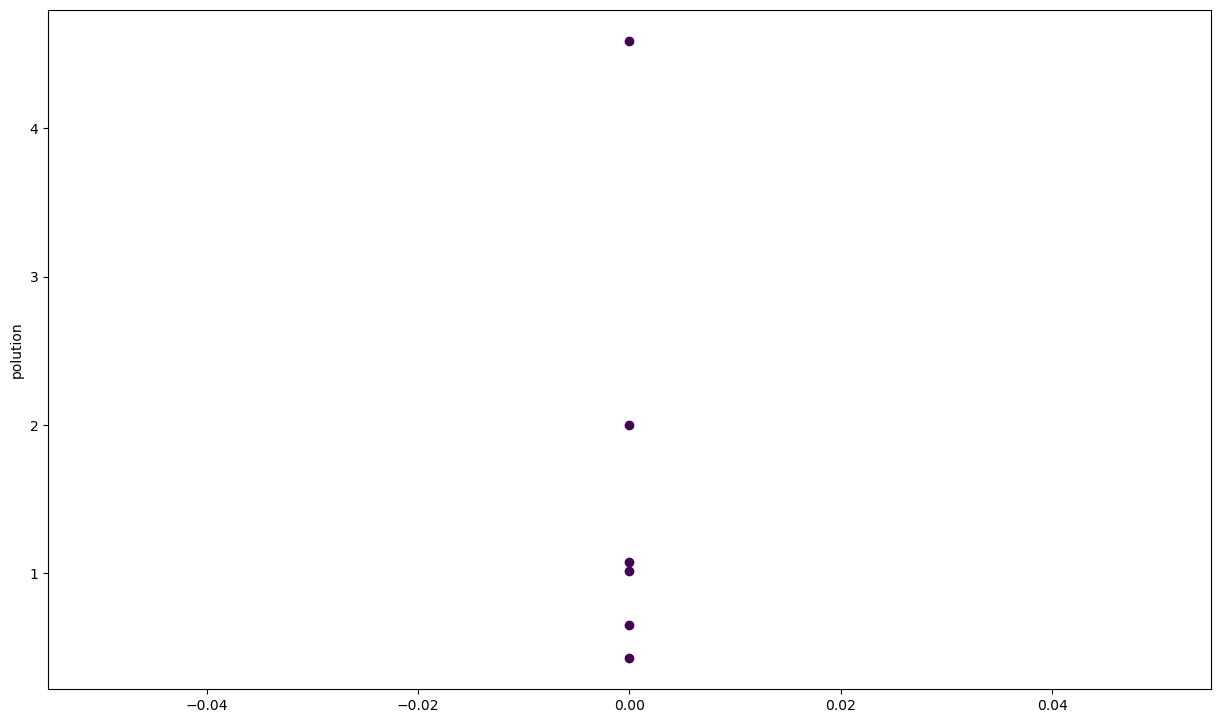

In [5]:
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from itertools import permutations

CONTRIES_OF_STUDY = {'Russia':'red', 'China': 'blue', 'India':'orange', 'European Union':'green', 'United States' : 'gray', 'Japan' : 'yellow' }

perm = []
for test in permutations(CONTRIES_OF_STUDY, len(CONTRIES_OF_STUDY)):
    perm.append(list(test))

T = 1
N = len(CONTRIES_OF_STUDY)

beta = [0.5, 0.04,0.03]
gamma = [0,0.1,1.94]

BETAS = np.array([beta[i] * np.ones(N) for i in range(len(beta))])
GAMMAS = np.array([gamma[i] * np.ones(N) for i in range(len(gamma))])

step_criterion = 10
utility_criterion = 0.000


TIME_STEP = 5
INITIAL_YEAR = 2015

plt.figure(figsize=(15, 9),dpi = 100)
ARRAY_TIMES = INITIAL_YEAR + np.arange(T) * TIME_STEP

actions = np.zeros(shape=(N,T))
e_max = np.zeros(shape=N)
data = pd.read_csv("data/data_of_interest.csv")
RCP = pd.read_csv('data/rcp_data.csv')
RCP_2_6 = np.array(RCP.loc[3][6:6+T])

k=0
for shuffled_contries in perm[:1]:
    for indice in range(N):
        contry = shuffled_contries[indice]
        e_max[indice] = data.loc[data['Entity']==contry,'CO2 emission in Gt 2020'].to_numpy()
        actions[indice] = RCP_2_6 * data.loc[data['Entity']==contry,'Population 2020 ratio'].to_numpy()
    BRD_action = best_response_dynamic(actions , e_max,  BETAS , GAMMAS , step_criterion, utility_criterion,diplay_progress=False)




    for indice in range(N):
        name = shuffled_contries[indice]
        color = indice
        plt.scatter(k, BRD_action[indice], label= name, c =color)
    k +=1
    


plt.ylabel('polution')
plt.show()


In [ ]:
test =dict(zip(CONTRIES_OF_STUDY, ['red', 'blue', 'orange', 'green', 'gray', 'yellow']))
print(test)
color = pd.DataFrame({'Russia':'red', 'China': 'blue', 'India':'orange', 'European Union':'green', 'United States' : 'gray', 'Japan' : 'yellow' }, index = 1)

print(color)
print(color['Russia'])

{'Russia': 'red', 'China': 'blue', 'India': 'orange', 'European Union': 'green', 'United States': 'gray', 'Japan': 'yellow'}


TypeError: Index(...) must be called with a collection of some kind, 1 was passed

In [6]:

BRD_action = best_response_dynamic(actions , e_max,  BETAS , GAMMAS , step_criterion, utility_criterion)


k: 0
loss: 1000
Reach the utlity criterion in 1 steps.


In [7]:
print(BRD_action.shape)

(6, 1)


In [24]:
import matplotlib.pyplot as plt

[2015]


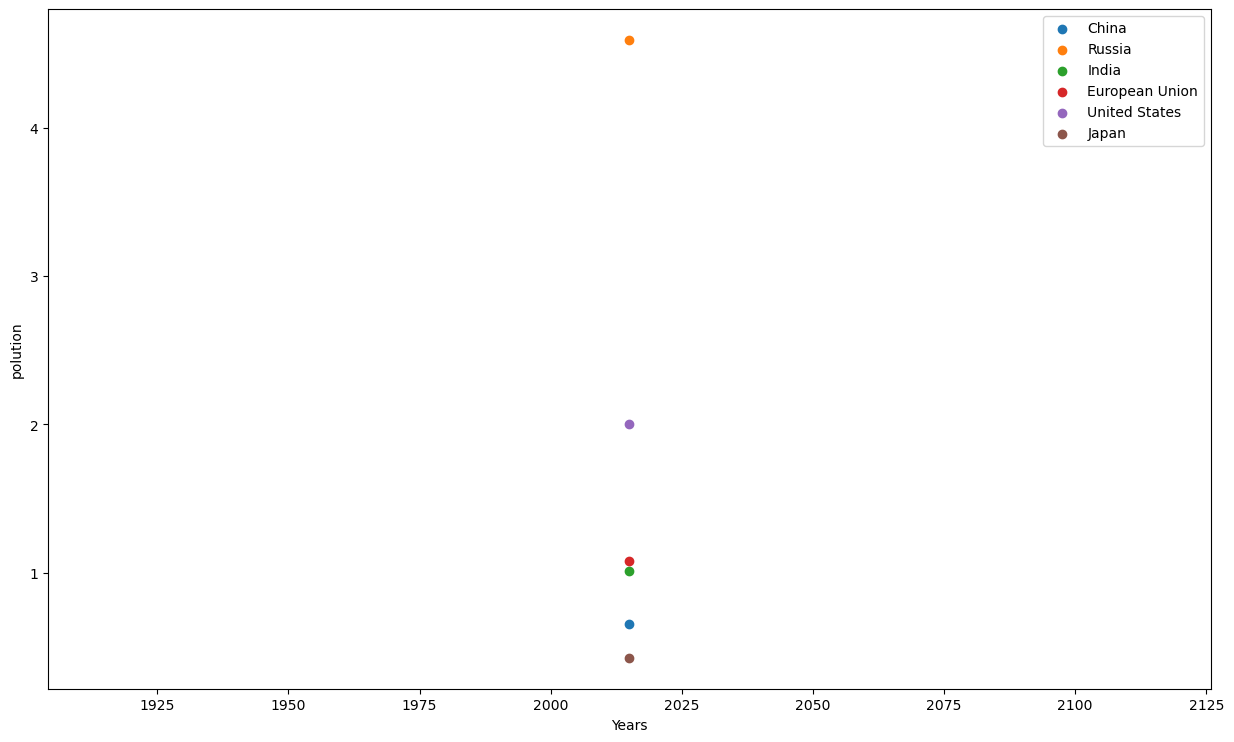

In [8]:
N, T = BRD_action.shape

TIME_STEP = 5
INITIAL_YEAR = 2015

plt.figure(figsize=(15, 9),dpi = 100)
ARRAY_TIMES = INITIAL_YEAR + np.arange(T) * TIME_STEP
print(ARRAY_TIMES)
CONTRIES_OF_STUDY = ['China', 'Russia', 'India', 'European Union', 'United States', 'Japan' ]
for i in range(N):
    plt.scatter(ARRAY_TIMES, BRD_action[i], label= CONTRIES_OF_STUDY[i])


plt.xlabel('Years')
plt.ylabel('polution')
plt.legend()
plt.show()

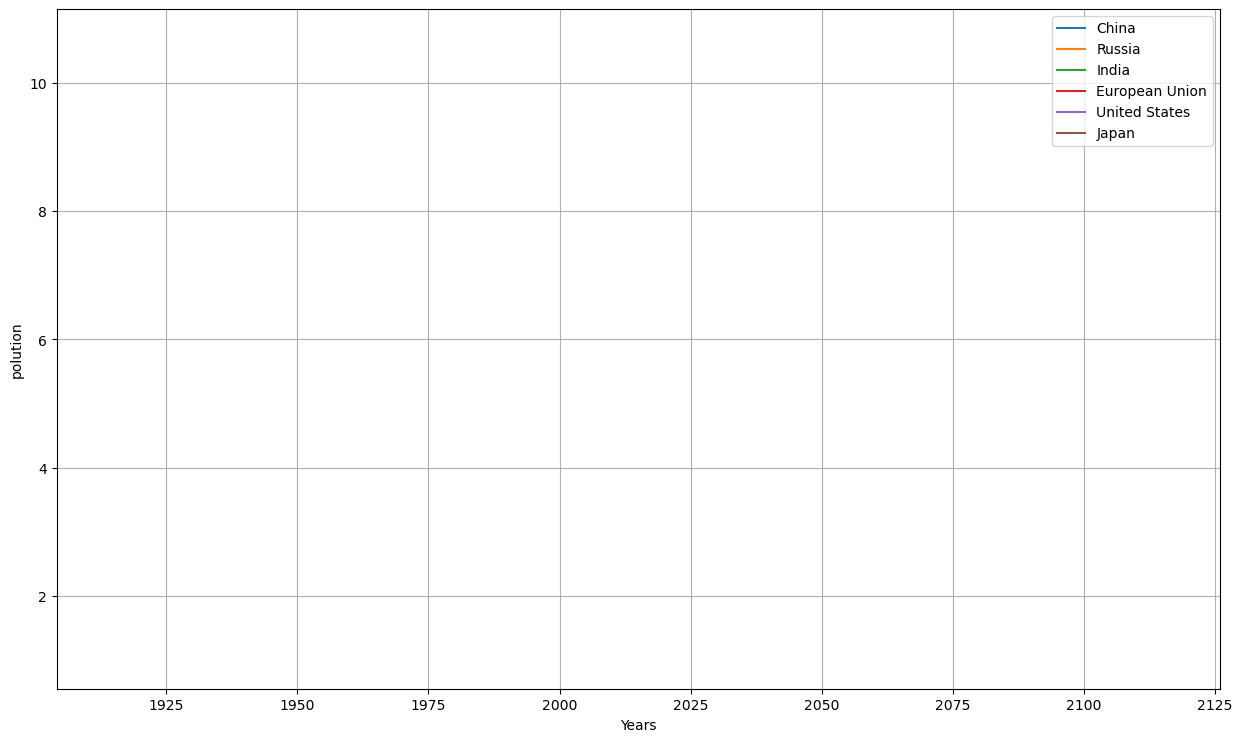

In [26]:
N, T = BRD_action.shape

TIME_STEP = 5
INITIAL_YEAR = 2015

plt.figure(figsize=(15, 9),dpi = 100)
plt.grid(which='both') 
ARRAY_TIMES = INITIAL_YEAR + np.arange(T) * TIME_STEP
 
CONTRIES_OF_STUDY = ['China', 'Russia', 'India', 'European Union', 'United States', 'Japan' ]
for i in range(N):
    plt.plot(ARRAY_TIMES, BRD_action[i], label= CONTRIES_OF_STUDY[i])


plt.xlabel('Years')
plt.ylabel('polution')
plt.legend()
plt.show()

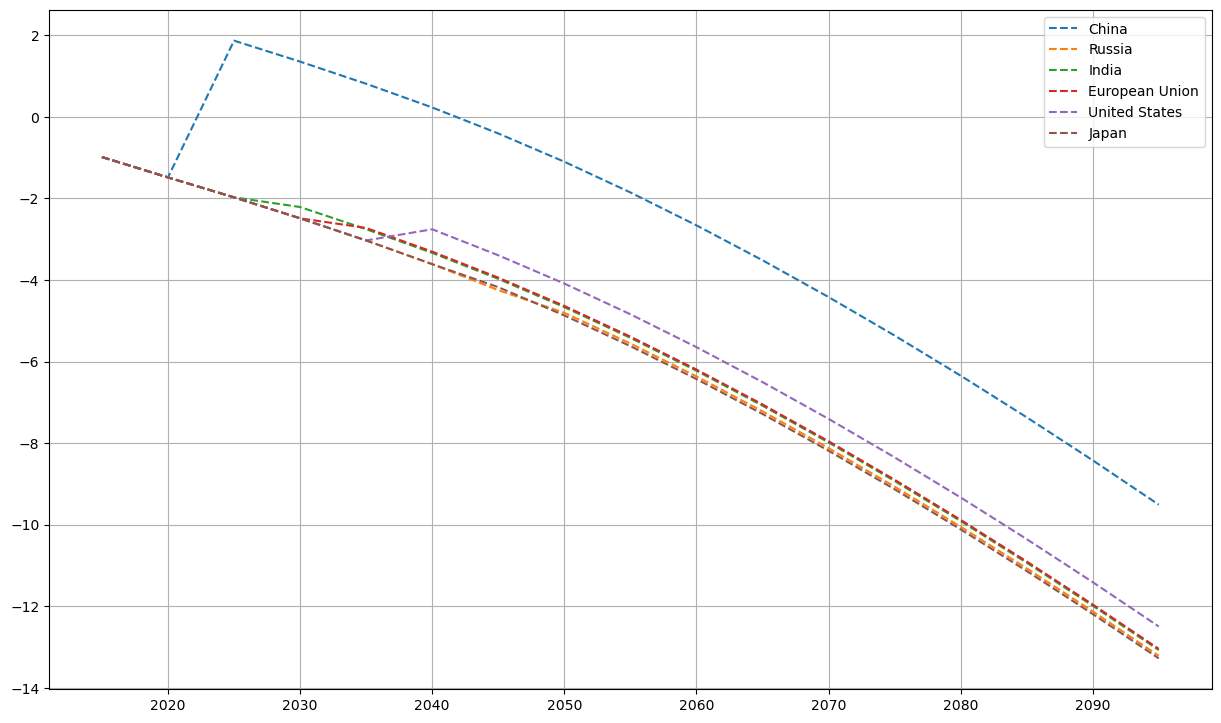

In [11]:
from model import DICE_2016
emissions = BRD_action
model = DICE_2016(2015, 2095, emissions)
plt.figure(figsize=(15, 9),dpi = 100)
plt.grid(which='both') 
for i in range(len(CONTRIES_OF_STUDY)):
    e_max_player = 1
    action = emissions[i]
    u = model.utility(BETAS[:,i], GAMMAS[:,i], e_max_player, action)

    plt.plot(model.ARRAY_TIMES, u, ls='--',label = '{}'.format(CONTRIES_OF_STUDY[i]))
plt.legend()
plt.show()

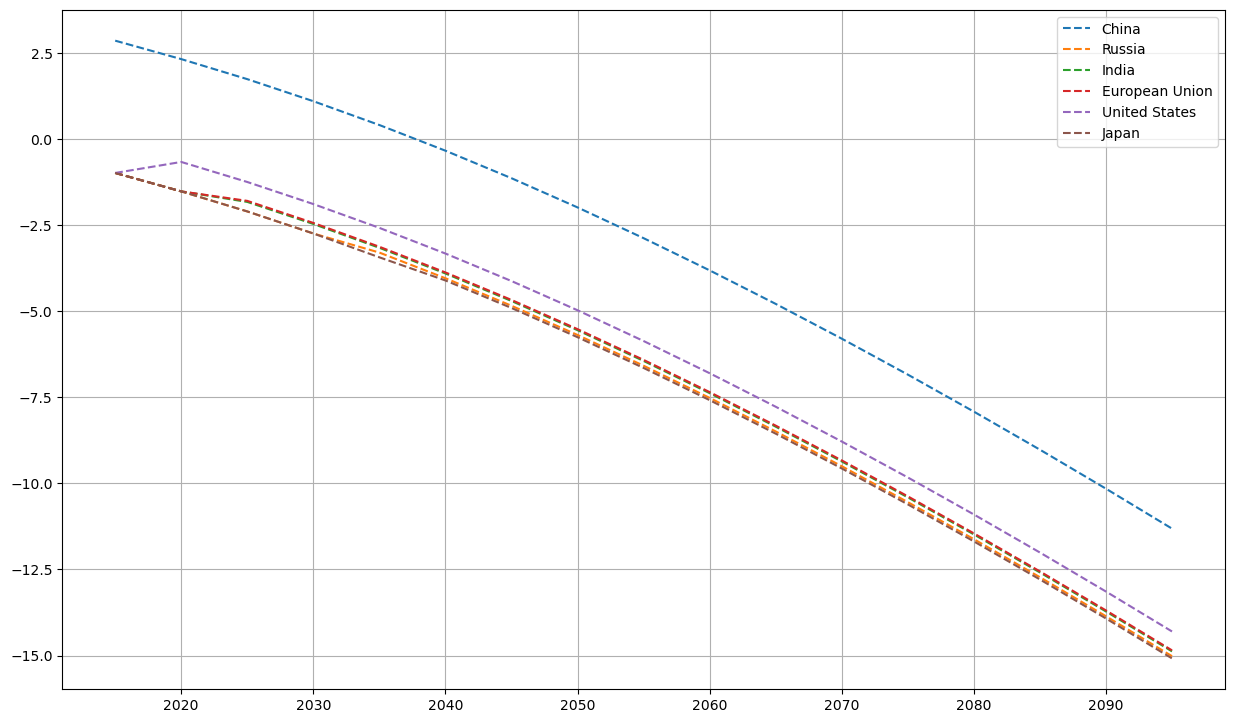

In [147]:
from model import DICE_2016
emissions = BRD_action
model = DICE_2016(2015, 2095, emissions)
plt.figure(figsize=(15, 9),dpi = 100)
plt.grid(which='both') 
for i in range(len(CONTRIES_OF_STUDY)):
    e_max_player = 1
    action = emissions[i]
    u = model.utility(BETAS[:,i], GAMMAS[:,i], e_max_player, action)

    plt.plot(model.ARRAY_TIMES, u, ls='--',label = '{}'.format(CONTRIES_OF_STUDY[i]))
plt.legend()
plt.show()

In [22]:
test = np.array([[1,1,1,1,1,1],
                 [1,1,1,1,1,1]])
test_2 = np.array([[1,1,1,1,1,1],
                 [1,1,1,1,1,1]])
print(np.sum(test, axis=0))
print(test[1,2])

[2 2 2 2 2 2]
1
